In [1]:
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm

In [2]:
# Setting the random seed so there is consistent data splitting between runs
tf.random.set_seed(42)
# importing the lowPPM matrix
allData = r"../Output/LowPPMMatrix.csv"

# Reading in the data to csv and removing any data at 150 ppm as this was incorrect data from testing
# NOTE: the 150 ppm is not in all outputs. but it is left in as a safeguard
df = pd.read_csv(allData)
df=df[df['Target PPM']!=150]
# Dropping all unneeded columns from the output
df = df.drop(columns=['Unnamed: 0','lowInterval','highInterval','Ratio'])
print(df.head())

# Declaring what sensor is used for the test set
test_sensor_id = 0  # Replace with the ID of the sensor you want in the test set
train_data = df[df['SensorID'] != test_sensor_id]
test_data = df[df['SensorID'] == test_sensor_id]

# Drop the SensorID column as we don't need it anymore
train_data = train_data.drop(columns=['SensorID'])
test_data = test_data.drop(columns=['SensorID'])
# Convert to TensorFlow tensors
train_data_tf = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(test_data, dtype=tf.float32)

   SensorID  Target PPM  Resistance  Temperature  RelativeHumidity
0       0.0         0.0   30.009404     0.795619          6.227832
1       3.0         0.0   28.086765     0.795619          6.227832
2       5.0         0.0   30.475486     0.795619          6.227832
3       7.0         0.0   31.911561     0.795619          6.227832
4       8.0         0.0   26.515605     0.795619          6.227832


In [3]:
# Randomizes the data for training to minimize fitting to false trends
train_data_shuffled = tf.random.shuffle(train_data_tf, seed=42)

# Separate features and labels
x_train, y_train = train_data_shuffled[:, 1:], train_data_shuffled[:, 0]
x_test, y_test = test_data_tf[:, 1:], test_data_tf[:, 0]

In [4]:
# Mean squared error function
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Root mean squared error function
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_pred, y_true))

# R-Squared function to test fit of model
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

# Used to trace history of RMSE as the neural network gets trained
class RMSEHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE = []
        self.validationRMSE = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE.append(logs.get('rmse'))
        self.validationRMSE.append(logs.get('val_rmse'))

In [5]:
rmse_history = RMSEHistory()
# Compile and train the model
input_shape = (x_train.shape[1],)

In [6]:
# Initialize a CSV file to store the results
csvfile = open('experiment_results.csv', 'w', newline='')
csvwriter = csv.writer(csvfile)
csvwriter.writerow(['BaseNum', 'Run', 'Test_RMSE', 'Test_Accuracy'])

for baseNum in tqdm(range(1, 33), desc='BaseNum Loop'):  # Wrap outer loop with tqdm
    for run in tqdm(range(1, 101), desc=f'Run Loop for BaseNum {baseNum}', leave=False):  # Wrap inner loop with tqdm


        def build_model(input_shape, regularization_factor=0.01):
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(baseNum * 2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
                tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(1)
            ])
            return model

        with tf.device('/GPU:0'):
            model = build_model(input_shape)
            model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
            model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[rmse_history],verbose=0)
            test_metrics = model.evaluate(x_test, y_test,verbose=0)
            test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
        # Save the results
        csvwriter.writerow([baseNum, run, test_rmse, test_accuracy])
        csvfile.flush()
csvfile.close()

BaseNum Loop:   0%|          | 0/32 [00:23<?, ?it/s]                   


KeyboardInterrupt: 

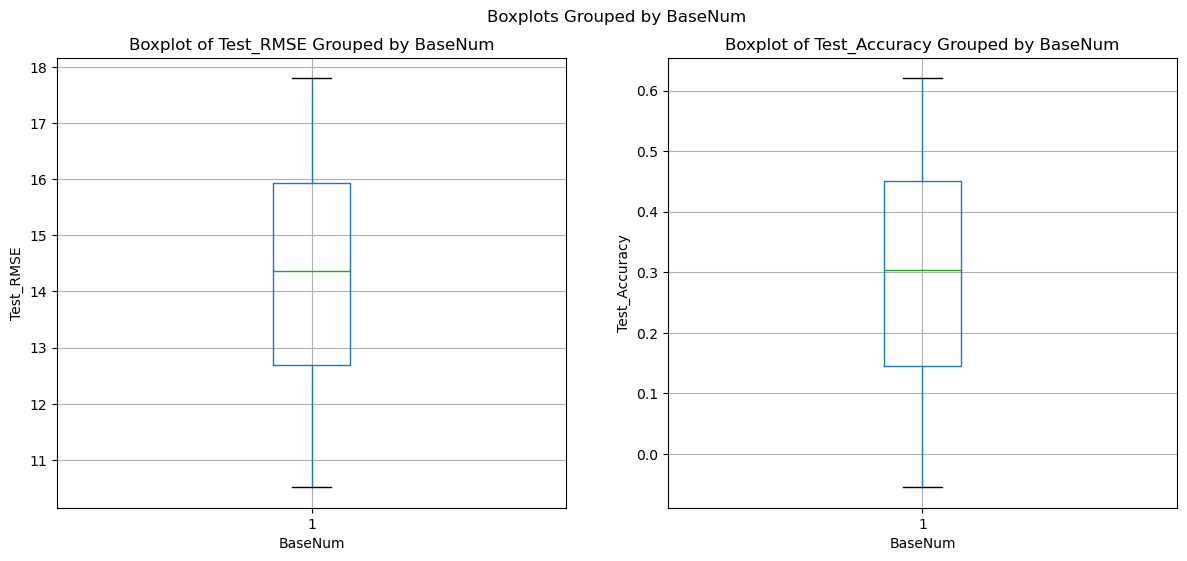

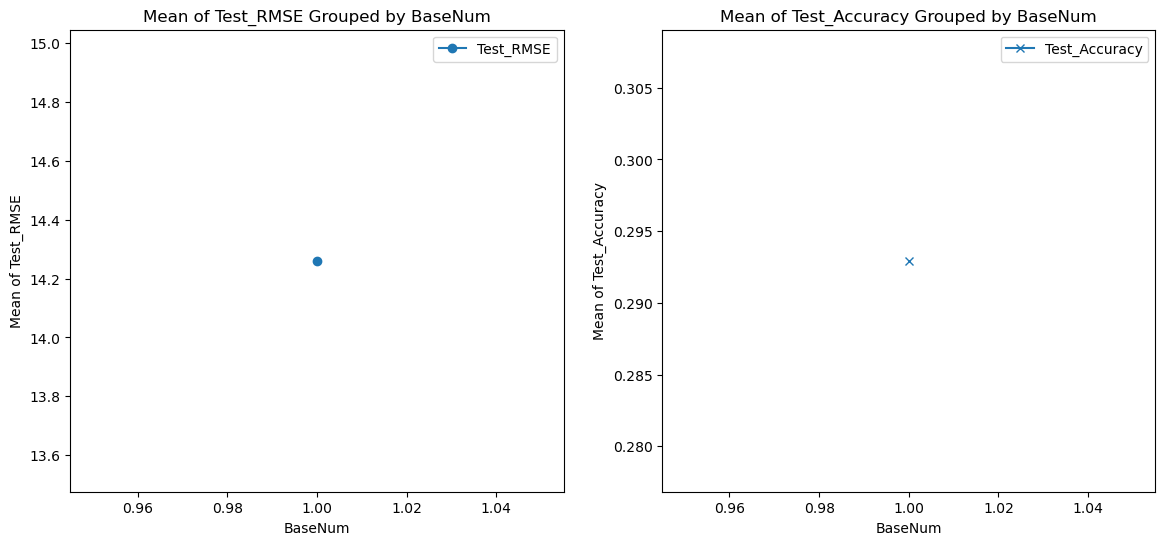

In [7]:
df1 = pd.read_csv("./experiment_results.csv")

# Create a figure and axis object for the boxplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Create a boxplot for Test_RMSE grouped by BaseNum
df1.boxplot(column='Test_RMSE', by='BaseNum', ax=ax[0])
ax[0].set_title('Boxplot of Test_RMSE Grouped by BaseNum')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Test_RMSE')

# Create a boxplot for Test_Accuracy grouped by BaseNum
df1.boxplot(column='Test_Accuracy', by='BaseNum', ax=ax[1])
ax[1].set_title('Boxplot of Test_Accuracy Grouped by BaseNum')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Test_Accuracy')

# Show the plots
plt.suptitle('Boxplots Grouped by BaseNum')
plt.show()

# Group by BaseNum and calculate the mean
grouped_means = df1.groupby('BaseNum').mean()

# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean of Test_RMSE
ax[0].plot(grouped_means.index, grouped_means['Test_RMSE'], label='Test_RMSE', marker='o')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Mean of Test_RMSE')
ax[0].set_title('Mean of Test_RMSE Grouped by BaseNum')
ax[0].legend()

# Plot the mean of Test_Accuracy
ax[1].plot(grouped_means.index, grouped_means['Test_Accuracy'], label='Test_Accuracy', marker='x')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Mean of Test_Accuracy')
ax[1].set_title('Mean of Test_Accuracy Grouped by BaseNum')
ax[1].legend()

# Show the plot
plt.show()

Epoch 1/1000
11/11 [==============================] - 0s 6ms/step - loss: 790.7565 - r_squared: -1.5919 - rmse: 28.0194 - val_loss: 583.6946 - val_r_squared: -1.2738 - val_rmse: 24.1060
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 660.2112 - r_squared: -1.1138 - rmse: 25.5412 - val_loss: 493.3780 - val_r_squared: -0.9188 - val_rmse: 22.1461
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 563.2143 - r_squared: -0.7997 - rmse: 23.4225 - val_loss: 420.1690 - val_r_squared: -0.6308 - val_rmse: 20.4174
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 476.4718 - r_squared: -0.5658 - rmse: 21.7008 - val_loss: 357.4814 - val_r_squared: -0.3846 - val_rmse: 18.8139
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 403.7426 - r_squared: -0.2895 - rmse: 20.0022 - val_loss: 323.3696 - val_r_squared: -0.2519 - val_rmse: 17.8895
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - lo

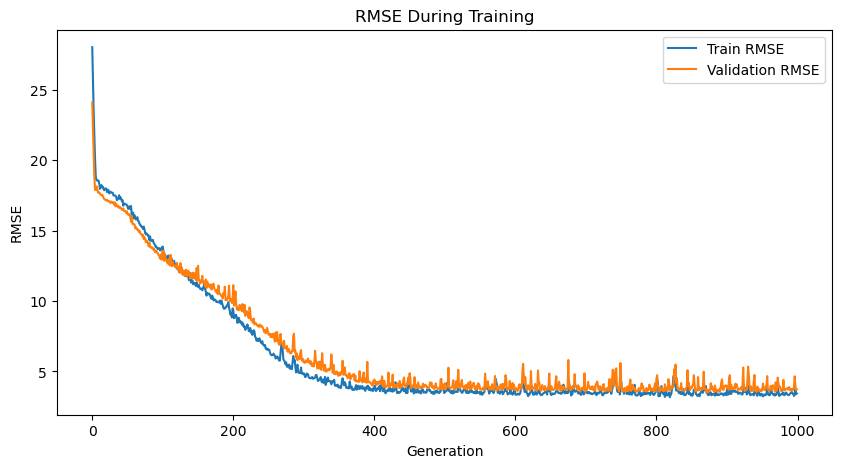

Epoch 1/200
11/11 [==============================] - 1s 8ms/step - loss: 17.6228 - r_squared: 0.9444 - rmse: 4.0497 - val_loss: 15.8972 - val_r_squared: 0.9428 - val_rmse: 3.8292
Epoch 2/200
11/11 [==============================] - 0s 2ms/step - loss: 12.5250 - r_squared: 0.9619 - rmse: 3.3819 - val_loss: 14.4183 - val_r_squared: 0.9496 - val_rmse: 3.5834
Epoch 3/200
11/11 [==============================] - 0s 2ms/step - loss: 12.2048 - r_squared: 0.9610 - rmse: 3.2940 - val_loss: 14.4507 - val_r_squared: 0.9490 - val_rmse: 3.6114
Epoch 4/200
11/11 [==============================] - 0s 2ms/step - loss: 11.5677 - r_squared: 0.9627 - rmse: 3.2841 - val_loss: 14.5901 - val_r_squared: 0.9487 - val_rmse: 3.6226
Epoch 5/200
11/11 [==============================] - 0s 2ms/step - loss: 13.3446 - r_squared: 0.9586 - rmse: 3.5512 - val_loss: 14.4474 - val_r_squared: 0.9497 - val_rmse: 3.5772
Epoch 6/200
11/11 [==============================] - 0s 2ms/step - loss: 16.1323 - r_squared: 0.9508 - rm

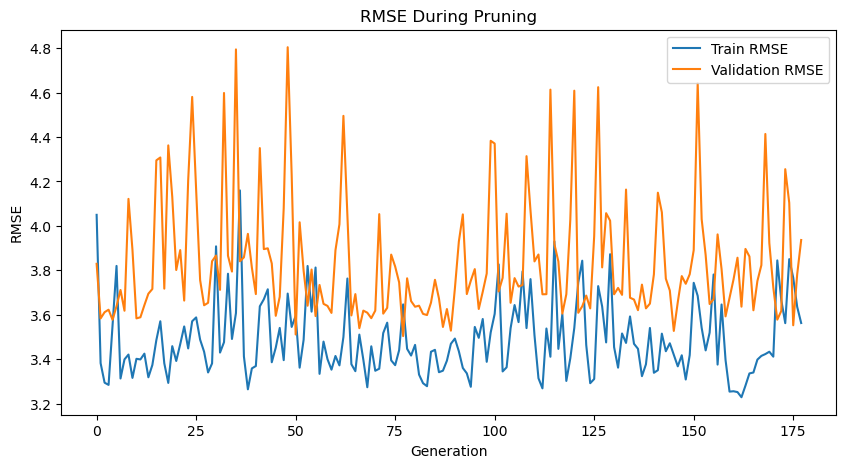

In [7]:
# NOTE: with =2 (Or any small int) it is hit or miss whether the model will go down the best optimized path. rerun a few times to determine what the best value is
#Used to quickly change size of neural net
baseNum = 4

# Define your original model with regularization
def build_model(input_shape, regularization_factor=0.01):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
        tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

with tf.device('/GPU:0'):
    #regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
    model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[rmse_history])
    # if no improvement has been made in 100 generations (epochs) stop the model
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
        print(f"Restoring model weights from the end of the best epoch.")
    else:
        print("Early stopping did not occur.")

    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")
    # Plotting RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(rmse_history.modelRMSE, label='Train RMSE')
    plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
    plt.xlabel('Generation')
    plt.ylabel('RMSE')
    plt.title('RMSE During Training')
    plt.legend()
    plt.show()

    # Pruning model. use the final_sparsity to trim the model. 0.5 means 50% of the nodes get trimmed, 0.9 means 90% of the nodes get trimmed. typically 0.6 is a good starting point for this
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
                                                    final_sparsity=0.0,
                                                    begin_step=len(x_train) // 50 * 10,
                                                    end_step=len(x_train) // 50 * 500)
    }

    model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared,rmse])

    callbacks = [
        sparsity.UpdatePruningStep(),
        early_stopping,
        rmse_history
    ]

    model_for_pruning.fit(x_train, y_train, epochs=200, batch_size=50, validation_split=0.2, callbacks=callbacks)

    # Remove the pruning wrappers to finalize the model
    model = sparsity.strip_pruning(model_for_pruning)
    model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])

if early_stopping.stopped_epoch > 0:
    print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
    print(f"Restoring model weights from the end of the best epoch.")
else:
    print("Early stopping did not occur.")

# Make predictions
with tf.device('/GPU:0'):  # This line is optional
    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")


# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_history.modelRMSE, label='Train RMSE')
plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.title('RMSE During Pruning')
plt.legend()
plt.show()
# model.save('MethaneModel.keras')

In [ ]:
# Used to save the model
model.save('MethaneModelBest391-2nodes.keras')

3/3 [==============================] - 0s 698us/step


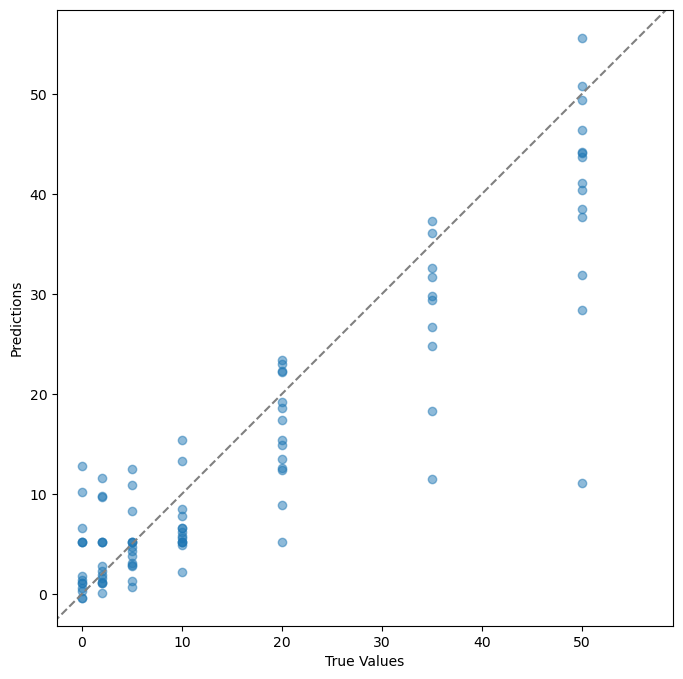

In [11]:
import matplotlib.pyplot as plt

# Generate predictions on the test data
with tf.device('/GPU:0'):  # Optional
    y_pred = model.predict(x_test)

# Flatten y_test and y_pred for plotting
y_test_flat = y_test.numpy().flatten()
y_pred_flat = y_pred.flatten()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')

# Plot a 45-degree line for reference
plt.plot([-100, 1200], [-100, 1200], '--', color='gray')

plt.show()


In [21]:
print(df.columns)

Index(['SensorID', 'Target PPM', 'Resistance', 'Temperature',
       'RelativeHumidity'],
      dtype='object')


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a grid for contour plotting
x_values = np.linspace(df['Resistance'].min(), df['Resistance'].max(), 100)
y_values = np.linspace(df['RelativeHumidity'].min(), df['RelativeHumidity'].max(), 100)
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Prepare the grid data for prediction
grid_data = np.c_[x_grid.ravel(), y_values.ravel()]
grid_data_tf = tf.convert_to_tensor(grid_data, dtype=tf.float32)

# Use the trained model to make predictions on the grid
with tf.device('/GPU:0'):
    pred_ppm = model.predict(grid_data_tf)

# Reshape the predicted data to match the grid shape
pred_ppm = pred_ppm.reshape(x_grid.shape)

# Create contour plot
plt.figure(figsize=(12, 10))
contour = plt.contourf(x_grid, y_grid, pred_ppm, 50, cmap='viridis')
plt.colorbar(label='Predicted PPM')

# Overlay actual data points
plt.scatter(df['Resistance'], df['RelativeHumidity'], c=df['Target PPM'], edgecolor='w', cmap='viridis')

# Labels and title
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Contour plot with actual data overlayed')
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10000 and the array at index 1 has size 100